In [14]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import os, io, sys
from PIL import Image
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
import json, re

model = YOLO("./runs/segment/train_blue_rawdata_1504_500_50epoch/weights/best.pt")
ipath = "./datasets/Blue-Rawdata-1504-500-1/valid/images/"

def calculate_iou(mask1, mask2):
    """
    计算两个二值掩码之间的 IoU。
    mask1 和 mask2 都是同样大小的 numpy 数组，
    前景像素值通常为 255（或非0），背景为 0。
    """
    # 如果前景值是 255，可以先转换为布尔值
    # 也可直接使用 mask1 > 0 的方式来获取前景区域
    m1 = (mask1 > 0)
    m2 = (mask2 > 0)

    intersection = np.logical_and(m1, m2).sum()  # 交集像素数
    union = np.logical_or(m1, m2).sum()          # 并集像素数

    if union == 0:
        # 如果两个掩码都完全没有前景，可能需要根据场景判断返回 1.0 还是 0.0
        return 1.0 if intersection == 0 else 0.0

    iou = intersection / union
    return iou

def sort_points_by_angle(points):
    """
    根据点相对于质心的极角进行排序（逆时针）。
    适用于 points.shape == (N, 2) 且 N >= 3 的情况。
    """
    # 1. 计算质心
    center = np.mean(points, axis=0)  # [cx, cy]

    # 2. 计算相对于质心的向量和角度
    #   atan2(y, x) 返回(-π, π)，能区分象限，不会出现排序纠纷
    angles = np.arctan2(points[:, 1] - center[1], points[:, 0] - center[0])

    # 3. 根据角度从小到大排序即可（默认升序）
    sorted_indices = np.argsort(angles)

    # 4. 返回排序后的点
    return points[sorted_indices]

In [15]:
iou_list = []
height_list = []
height_diff = []
height_diff_percent = []
for i, image_name in enumerate(os.listdir(ipath)):
    if not image_name.lower().endswith('.jpg'):
        continue
    # image_name = '2022-03-28_143344_39_T5_2334_bmp_jpg.rf.03672cb0b717b22356ea1aa5976e7b24.jpg'
    # truth label points for bloodzone2

    json_name  = '../../data/rawdata/class1/' + image_name[:re.search(r'_bmp', image_name).start()] + '.json'
    with open(json_name, 'r') as f:
        data = json.load(f)

    image_path = os.path.join(ipath, image_name)
    # image = cv2.imread(image_path)
    image = np.array(Image.open(image_path))
    annotated_image = image.copy()

    ## predicted label
    results = model(source = image, imgsz = 1504, 
                    device="cuda:0",
                    visualize = False, show = False, 
                    save = False, save_txt = False, save_conf = False, save_crop = False,
                    show_labels = False, show_conf = False, show_boxes = False, line_width = 2)
    
    cls_dict = results[0].names
    bloodzone2_id = [i for i, id in enumerate(list(results[0].boxes.cls.cpu().numpy())) if id == 1]
    if len(bloodzone2_id) > 0:
        points_list = []
        for i in bloodzone2_id:
            result = results[0][i]
            # mask = np.zeros(result.orig_shape, dtype=np.uint8)
            points = result.masks.xyn[0]
            points[:, 0] *= results[0].orig_shape[0]
            points[:, 1] *= results[0].orig_shape[1]
            points_list.append(points)

        points = np.vstack(points_list)
        points = points.astype(np.int32)
        height = np.mean(np.sort(points[:, 1])[:2])
        # points = sort_points_by_angle(points)
        # cv2.fillPoly(mask, [points], 255)
        mask = result.masks.data.cpu().numpy()[0]
        mask = cv2.resize(mask, (1500, 1500), interpolation=cv2.INTER_NEAREST)

        print('detected')
        cv2.polylines(annotated_image, points.reshape((-1, 1, 2)), isClosed=True, color=(0, 255, 0), thickness=5)
        # cv2.putText(annotated_image, str(class_id), (points[0][0], points[0][1] - 10), 
        # cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1, cv2.LINE_AA)
            
        ## true label
        true_mask = np.zeros(result.orig_shape, dtype=np.uint8)
        true_points = []
        for id, shape in enumerate(data["shapes"]):
            if id >= 2 and id <= 5:
                true_point = shape["points"][0]
                x, y = int(true_point[0]), int(true_point[1])
                # print(x, y)
                x, y = int((x - 800) * 1500/1200), int((y - 250) * 1)
                # print(x, y)
                true_points.append([x, y])
                cv2.circle(annotated_image, (x, y), radius=5, color=(255, 0, 0), thickness=-1)  # Red dot

        true_points = np.array(true_points, dtype=np.int32)
        true_points = sort_points_by_angle(true_points)
        true_height = np.mean(np.sort(true_points[:, 1])[:1])
        y_values = points[:, 1]

        cv2.fillPoly(true_mask, [true_points], 255)

        # plt.imshow(annotated_image)
        # plt.imsave(f'../../img/{i}.jpg', annotated_image)
        # plt.show()
        # break
        
        print(true_height, height, true_height - height, f'{round((true_height - height)/true_height*100, 2)}%')
        iou  = calculate_iou(true_mask, mask)
        print(iou)

        height_list.append(true_height)
        height_diff.append(abs(true_height - height))
        height_diff_percent.append(abs((true_height - height)/true_height))
        iou_list.append(iou)
        break

print('Average IOU', np.mean(iou_list))
print('Average pixel difference', np.mean(height_diff))
print('Average pixel difference %', f'{round(np.mean(height_diff_percent)*100, 2)}%')


0: 1504x1504 1 0, 105.7ms
Speed: 7.4ms preprocess, 105.7ms inference, 2.0ms postprocess per image at shape (1, 3, 1504, 1504)

0: 1504x1504 1 0, 103.5ms
Speed: 7.1ms preprocess, 103.5ms inference, 1.0ms postprocess per image at shape (1, 3, 1504, 1504)

0: 1504x1504 1 0, 102.7ms
Speed: 7.0ms preprocess, 102.7ms inference, 2.0ms postprocess per image at shape (1, 3, 1504, 1504)

0: 1504x1504 1 0, 103.0ms
Speed: 7.2ms preprocess, 103.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1504, 1504)

0: 1504x1504 1 2, 101.8ms
Speed: 6.5ms preprocess, 101.8ms inference, 2.0ms postprocess per image at shape (1, 3, 1504, 1504)

0: 1504x1504 1 2, 104.0ms
Speed: 7.0ms preprocess, 104.0ms inference, 1.0ms postprocess per image at shape (1, 3, 1504, 1504)

0: 1504x1504 1 0, 103.7ms
Speed: 6.5ms preprocess, 103.7ms inference, 1.0ms postprocess per image at shape (1, 3, 1504, 1504)

0: 1504x1504 1 0, 103.4ms
Speed: 6.5ms preprocess, 103.4ms inference, 3.0ms postprocess per image at shape (1,

C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\numpy\_core\fromnumeric.py:3904: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\ASUS\AppData\Roaming\Python\Python312\site-packages\numpy\_core\_methods.py:147: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [16]:
iou_list

[]

In [256]:
iou_list, height_diff

([np.float64(0.6290556900726392)], [np.float64(0.0)])

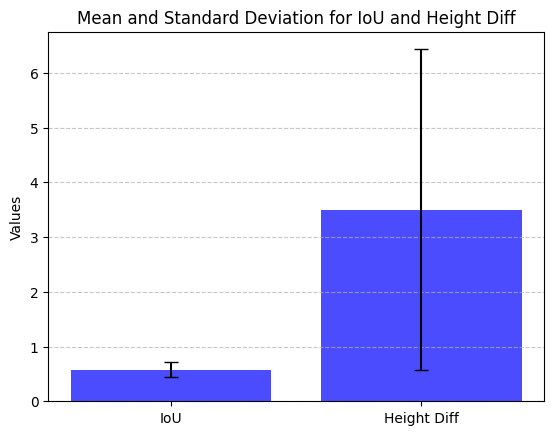

In [209]:
means = [np.mean(iou_list), np.mean(height_diff)]
stds = [np.std(iou_list), np.std(height_diff)]

# 横坐标标签
x_labels = ['IoU', 'Height Diff']

# 绘制带误差条的条形图
x_pos = np.arange(len(means))
colors = ['blue', 'blue']  # 两个纵坐标颜色统一

plt.bar(x_pos, means, yerr=stds, capsize=5, color=colors, alpha=0.7)

# 图形美化
plt.xticks(x_pos, x_labels)
plt.title('Mean and Standard Deviation for IoU and Height Diff')
plt.ylabel('Values')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 显示图像
plt.show()

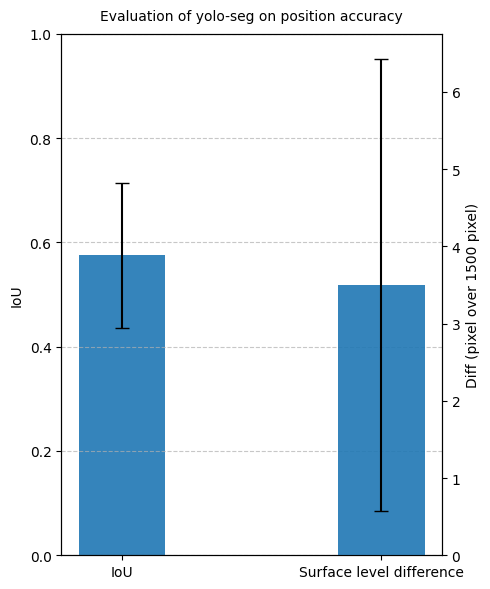

In [242]:
fig, ax1 = plt.subplots(figsize=(5, 6))
bar_width = 0.4
x1, x2 = 0.4, 1.6
color='black'
ax1.bar(x=x1, height=np.mean(iou_list), yerr=np.std(iou_list), capsize=5, color='C0', alpha=0.9, width=bar_width)
ax1.set_ylabel('IoU', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim([0, 1.])

ax2 = ax1.twinx()
ax2.bar(x=x2, height=np.mean(height_diff), yerr=np.std(height_diff), capsize=5, color='C0', alpha=0.9, width=bar_width)
ax2.set_ylabel('Diff (pixel over 1500 pixel)', color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.xticks([x1, x2], ['IoU', 'Surface level difference'])
plt.title('Evaluation of yolo-seg on position accuracy', fontsize=10, pad=10)

ax1.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [249]:
np.shape(true_mask)

(1500, 1500)

In [250]:
true_mask

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

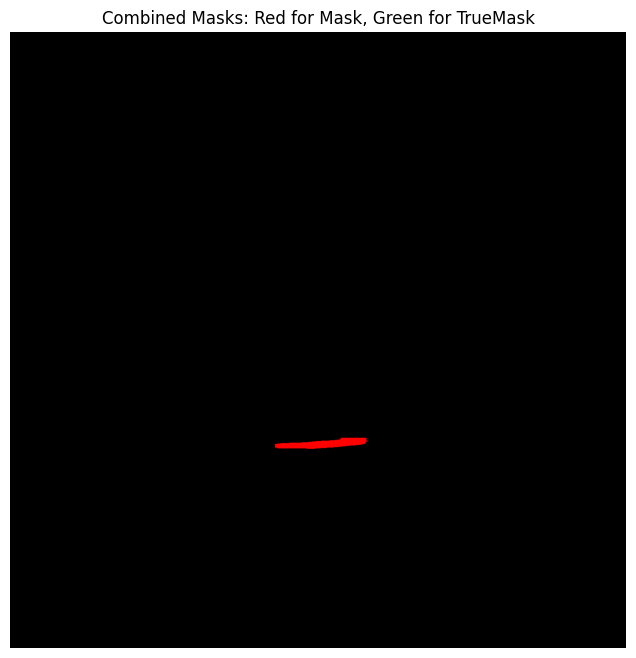

In [257]:
combined_image = np.zeros((1500, 1500, 3), dtype=np.uint8)
combined_image[..., 0] = mask * 255  # 红色通道
combined_image[..., 1] = true_mask * 255  # 绿色通道

plt.figure(figsize=(8, 8))
plt.imshow(combined_image)
plt.title('Combined Masks: Red for Mask, Green for TrueMask')
plt.axis('off')
plt.show()

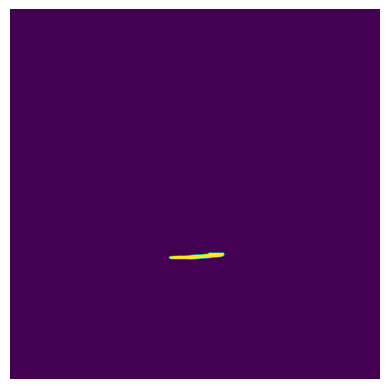

In [258]:
mask = result.masks.data.cpu().numpy()[0]
mask = cv2.resize(mask, (1500, 1500), interpolation=cv2.INTER_NEAREST)
plt.imshow(mask)
plt.axis('off')  # 不显示坐标轴
plt.show()

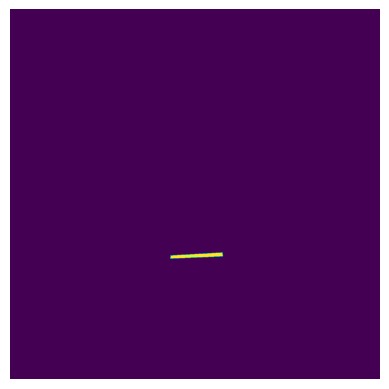

In [259]:
plt.imshow(true_mask)
plt.axis('off')  # 不显示坐标轴
plt.show()

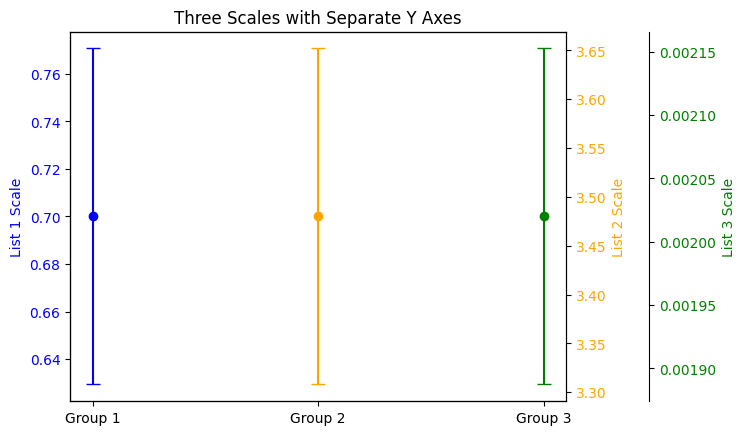

In [198]:
import matplotlib.pyplot as plt
import numpy as np

# 数据
list1 = [0.6, 0.8, 0.7, 0.65, 0.75]
list2 = [3.2, 3.6, 3.4, 3.7, 3.5]
list3 = [0.0018, 0.0022, 0.002, 0.0021, 0.002]

# 计算均值和标准差
means = [np.mean(list1), np.mean(list2), np.mean(list3)]
stds = [np.std(list1), np.std(list2), np.std(list3)]

x = np.arange(len(means))  # 生成适合的 x 坐标索引 [0, 1, 2]

# 替换 None 为 NaN
y1 = [means[0], np.nan, np.nan]
y2 = [np.nan, means[1], np.nan]
y3 = [np.nan, np.nan, means[2]]

yerr1 = [stds[0], np.nan, np.nan]
yerr2 = [np.nan, stds[1], np.nan]
yerr3 = [np.nan, np.nan, stds[2]]

# 创建一个主图
fig, ax1 = plt.subplots()

# 绘制第一个数据集
ax1.errorbar(x, y1, yerr=yerr1, fmt='o', capsize=5, color='blue', label='List 1')
ax1.set_ylabel('List 1 Scale', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# 添加第二个 y 轴
ax2 = ax1.twinx()
ax2.errorbar(x, y2, yerr=yerr2, fmt='o', capsize=5, color='orange', label='List 2')
ax2.set_ylabel('List 2 Scale', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 添加第三个 y 轴
ax3 = ax1.twinx()
ax3.spines['right'].set_position(('outward', 60))  # 移动第三个 y 轴
ax3.errorbar(x, y3, yerr=yerr3, fmt='o', capsize=5, color='green', label='List 3')
ax3.set_ylabel('List 3 Scale', color='green')
ax3.tick_params(axis='y', labelcolor='green')

# 设置 x 轴标签
plt.xticks(x, ['Group 1', 'Group 2', 'Group 3'])

plt.title('Three Scales with Separate Y Axes')
plt.show()


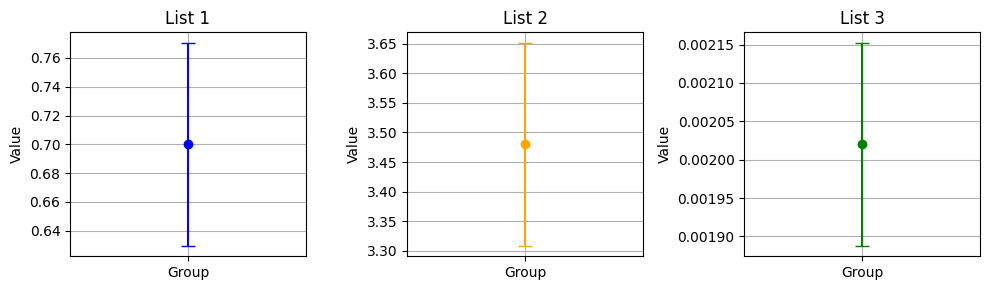

In [195]:
fig, axes = plt.subplots(1, 3, figsize=(10, 3), sharex=True)

# 绘制每个子图
colors = ['blue', 'orange', 'green']
lists = [list1, list2, list3]
titles = ['List 1', 'List 2', 'List 3']

for i, ax in enumerate(axes):
    mean = np.mean(lists[i])
    std = np.std(lists[i])
    ax.errorbar(['Group'], [mean], yerr=[std], fmt='o', capsize=5, color=colors[i])
    ax.set_title(titles[i])
    ax.set_ylabel('Value')
    ax.grid(True)

# 设置共享的 x 轴
# axes[-1].set_xlabel('Groups')

plt.tight_layout()
plt.show()


In [60]:
np.shape(result.masks.data)

torch.Size([1, 1504, 1504])

In [110]:
points

array([[624, 875],
       [624, 886],
       [628, 886],
       [629, 887],
       [635, 887],
       [636, 886],
       [675, 886],
       [676, 887],
       [688, 887],
       [689, 888],
       [709, 888],
       [710, 889],
       [722, 889],
       [723, 890],
       [730, 890],
       [731, 891],
       [737, 891],
       [738, 892],
       [744, 892],
       [745, 893],
       [752, 893],
       [753, 894],
       [760, 894],
       [761, 895],
       [764, 895],
       [765, 896],
       [767, 896],
       [768, 897],
       [771, 897],
       [772, 898],
       [793, 898],
       [794, 899],
       [794, 902],
       [802, 902],
       [802, 899],
       [803, 898],
       [809, 898],
       [810, 897],
       [811, 897],
       [813, 895],
       [813, 894],
       [815, 892],
       [818, 892],
       [818, 885],
       [815, 885],
       [814, 884],
       [811, 884],
       [810, 883],
       [800, 883],
       [799, 882],
       [786, 882],
       [785, 881],
       [780,

In [62]:
masks = results[0].masks
xy_coords = masks.xy
print(len(xy_coords))  # Number of masks
print(xy_coords[0].shape)  # Shape of first mask's coordinates

1
(59, 2)


In [ ]:
results[0].masks

In [129]:
print(points.shape)
print(points.reshape((-1,1,2)).shape)


(17, 2)
(17, 1, 2)


In [118]:
type(image)

PIL.JpegImagePlugin.JpegImageFile

In [94]:
results[0].orig_shape[0]

640

In [85]:
cls_dict = results[0].names

[cls_dict[result.boxes.cls.item()] for result in results[0]]

['2', '0', '1']

In [69]:
len(results[0])

3

In [82]:
results[0][0].boxes.cls.item()

2.0

In [ ]:
results[0].xyn.top1

AttributeError: 'Results' object has no attribute 'xyn'. See valid attributes below.

    A class for storing and manipulating inference results.

    This class encapsulates the functionality for handling detection, segmentation, pose estimation,
    and classification results from YOLO models.

    Attributes:
        orig_img (numpy.ndarray): Original image as a numpy array.
        orig_shape (Tuple[int, int]): Original image shape in (height, width) format.
        boxes (Boxes | None): Object containing detection bounding boxes.
        masks (Masks | None): Object containing detection masks.
        probs (Probs | None): Object containing class probabilities for classification tasks.
        keypoints (Keypoints | None): Object containing detected keypoints for each object.
        obb (OBB | None): Object containing oriented bounding boxes.
        speed (Dict[str, float | None]): Dictionary of preprocess, inference, and postprocess speeds.
        names (Dict[int, str]): Dictionary mapping class IDs to class names.
        path (str): Path to the image file.
        _keys (Tuple[str, ...]): Tuple of attribute names for internal use.

    Methods:
        update: Updates object attributes with new detection results.
        cpu: Returns a copy of the Results object with all tensors on CPU memory.
        numpy: Returns a copy of the Results object with all tensors as numpy arrays.
        cuda: Returns a copy of the Results object with all tensors on GPU memory.
        to: Returns a copy of the Results object with tensors on a specified device and dtype.
        new: Returns a new Results object with the same image, path, and names.
        plot: Plots detection results on an input image, returning an annotated image.
        show: Shows annotated results on screen.
        save: Saves annotated results to file.
        verbose: Returns a log string for each task, detailing detections and classifications.
        save_txt: Saves detection results to a text file.
        save_crop: Saves cropped detection images.
        tojson: Converts detection results to JSON format.

    Examples:
        >>> results = model("path/to/image.jpg")
        >>> for result in results:
        ...     print(result.boxes)  # Print detection boxes
        ...     result.show()  # Display the annotated image
        ...     result.save(filename="result.jpg")  # Save annotated image
    

In [42]:
np.shape(results[0].masks.xyn[2])

(16, 2)

In [27]:
np.shape(results[0].orig_img)

(640, 640, 3)

In [35]:
(results[0].masks.xy[2]/640).astype(np.float64)

array([[    0.38438,     0.59688],
       [    0.38438,     0.60625],
       [    0.39375,     0.60625],
       [    0.39531,     0.60781],
       [    0.40156,     0.60781],
       [    0.40312,     0.60938],
       [    0.40312,     0.61406],
       [    0.52188,     0.61406],
       [    0.52188,     0.60938],
       [    0.52344,     0.60781],
       [    0.52969,     0.60781],
       [    0.53125,     0.60625],
       [    0.54219,     0.60625],
       [    0.54375,     0.60469],
       [    0.55156,     0.60469],
       [    0.55156,     0.59688]])

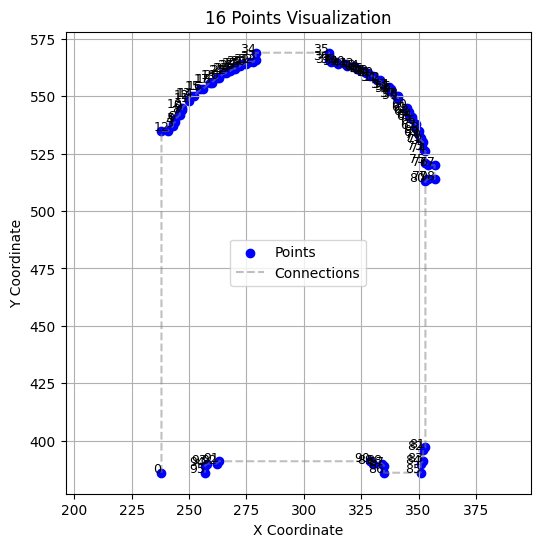

In [25]:
x = results[0].masks.xy[0][:, 0]
y = results[0].masks.xy[0][:, 1]

# 创建散点图
plt.figure(figsize=(6, 6))  # 设置图像大小
plt.scatter(x, y, color='blue', label='Points')  # 绘制散点
plt.plot(x, y, linestyle='--', color='gray', alpha=0.5, label='Connections')  # 连接点

# 添加点的标注
for i, (px, py) in enumerate(zip(x, y)):
    plt.text(px, py, f'{i}', fontsize=9, ha='right')

# 设置图例和标题
plt.legend()
plt.title("16 Points Visualization")
plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.grid(True)
plt.axis('equal')  # 保证 x 和 y 坐标的比例一致
plt.show()

In [19]:
results[0].masks.xy[0]

array([[        238,         386],
       [        238,         535],
       [        241,         535],
       [        243,         537],
       [        243,         538],
       [        244,         539],
       [        244,         540],
       [        246,         542],
       [        246,         543],
       [        247,         544],
       [        247,         545],
       [        250,         548],
       [        250,         549],
       [        251,         550],
       [        252,         550],
       [        255,         553],
       [        256,         553],
       [        259,         556],
       [        260,         556],
       [        262,         558],
       [        263,         558],
       [        265,         560],
       [        266,         560],
       [        267,         561],
       [        268,         561],
       [        269,         562],
       [        270,         562],
       [        271,         563],
       [        272,

torch.Size([3, 1504, 1504])


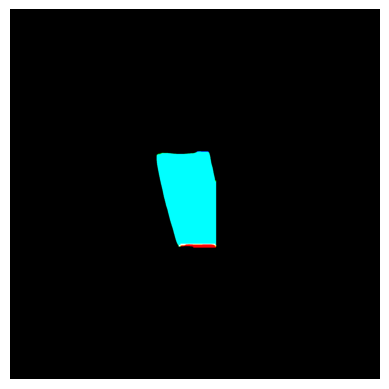

In [129]:
print(np.shape(results[0].masks.data))
x = results[0].masks.data.permute(1, 2, 0).cpu().numpy()
plt.imshow(x)
plt.axis('off')  # 不显示坐标轴
plt.show()

In [134]:
results[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([1., 0., 2.], device='cuda:0')
conf: tensor([0.6889, 0.5815, 0.3817], device='cuda:0')
data: tensor([[6.8343e+02, 9.5183e+02, 8.3931e+02, 9.6508e+02, 6.8891e-01, 1.0000e+00],
        [5.8929e+02, 5.7447e+02, 8.3176e+02, 9.6008e+02, 5.8149e-01, 0.0000e+00],
        [5.8846e+02, 5.7792e+02, 8.3128e+02, 9.5981e+02, 3.8166e-01, 2.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1500, 1500)
shape: torch.Size([3, 6])
xywh: tensor([[761.3657, 958.4579, 155.8798,  13.2505],
        [710.5255, 767.2731, 242.4700, 385.6118],
        [709.8682, 768.8659, 242.8220, 381.8932]], device='cuda:0')
xywhn: tensor([[0.5076, 0.6390, 0.1039, 0.0088],
        [0.4737, 0.5115, 0.1616, 0.2571],
        [0.4732, 0.5126, 0.1619, 0.2546]], device='cuda:0')
xyxy: tensor([[683.4258, 951.8326, 839.3055, 965.0831],
        [589.2905, 574.4672, 831.7604, 960.0790],
        [588.4572, 577.9193, 831.2792, 959.8125]], device='cuda:0'